In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

VER = 175
POSTFIX = ''

PART = 1

USE = 'orders'

CT=100

In [2]:
import pandas as pd, cudf, numpy as np, gc
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt

In [3]:
users = pd.read_parquet(f'../../data/infer_with_features/train_v{VER}_LB_{PART}.pqt')
print( users.shape )
users.head()

(41795000, 201)


,user,item,pos,wgt,score_1,score_3,score_4,score_5,score_6,score_7,score_10,score_11,score_12,score_13,score_30,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,buy_ratio_5,count_item_5,count_user_5,repeat_5,buy_ratio_std_5,item_day_std_5,user_day_std_5,buy_ratio_0_6,buy_ratio_1_6,buy_ratio_2_6,buy_ratio_3_6,buy_ratio_4_6,buy_ratio_5_6,buy_ratio_6_6,count_item_0_6,count_item_1_6,count_item_2_6,count_item_3_6,count_item_4_6,count_item_5_6,count_item_6_6,count_user_0_6,count_user_1_6,count_user_2_6,count_user_3_6,count_user_4_6,count_user_5_6,count_user_6_6,item_day_std_6,user_day_std_6,buy_ratio,count_item,count_user,hour_mean,day_mean,repeat,buy_ratio_std,hour_std,day_std,buy_ratio3,count_item3,count_user3,hour_mean3,day_mean3,repeat3,buy_ratio_std3,hour_std3,day_std3,prev3,next3,orders3,carts3,order_repeat3,cart_repeat3,buy_ratio2,count_item2,unique_item2,hour_mean2,day_mean2,repeat2,buy_ratio_std2,hour_std2,day_std2,ts_max7,ts_min7,ts_diff7,z1,z2,z3,z4,z5,z6,buy_ratio7,count_item7,count_user7,hour_mean7,day_mean7,repeat7,buy_ratio_std7,hour_std7,day_std7,prev7,next7,orders7,carts7,order_repeat7,cart_repeat7,buy_ratio8,count_item8,count_user8,hour_mean8,day_mean8,repeat8,buy_ratio_std8,hour_std8,day_std8,prev8,next8,orders8,carts8,order_repeat8,cart_repeat8,buy_ratio9,count_item9,count_user9,hour_mean9,day_mean9,repeat9,buy_ratio_std9,hour_std9,day_std9,prev9,next9,orders9,carts9,order_repeat9,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10,z10,z11,buy_ratio11,count_item11,count_user11,hour_mean11,day_mean11,repeat11,buy_ratio_std11,hour_std11,day_std11,buy_ratio12,count_item12,count_user12,hour_mean12,day_mean12,repeat12,buy_ratio_std12,hour_std12,day_std12,buy_ratio13,count_item13,count_user13,hour_mean13,day_mean13,repeat13,buy_ratio_std13,hour_std13,day_std13,buy_ratio14,count_item14,unique_item14,hour_mean14,day_mean14,repeat14,buy_ratio_std14,hour_std14,day_std14,buy_ratio15,count_item15,unique_item15,hour_mean15,day_mean15,repeat15,buy_ratio_std15,hour_std15,day_std15
0,12899779,59625,0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.414214,-1.0,0.071773,-1.0,-1.000,1.414214,1.414214,1.414214,1.414214,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,4.0,4.0,1.000000,0.000000,NaN,NaN,0.0,-1.00,-1.000000,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.377964,0.377964,0.000000,7.0,6.0,58189.570312,292703.84375,1.166667,0.000000,22522.156250,177373.40625,0.000000,1.0,1.0,79200.000000,338400.0000,1.00,-1.000000,-1.000000,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,0,0,0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,2.0,2.0,64435.000000,150835.00000,1.000000,0.000000,8051.117676,114136.937500,2.0,2.0,0.0,0.0,-1.0,-1.0,0.000000,6.0,5.0,66307.000000,325507.00000,1.200000,0.000000,7429.592773,169454.437500,5.0,5.0,0.0,0.0,-1.0,-1.0,0.000000,1.0,1.0,9485.000000,95885.00000,1.000000,-1.000000,-1.000000,-1.000000,1.0,1.0,0.0,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12899779,731692,1,10.675,1.0,-3.0,-3.0,-3.0,0.5,-3.0,-3.000000,1.5,0.300000,4.0,5.990,-3.000000,-3.000000,-3.000000,-3.000000,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,1.0,0.5,1.0,0.140000,50.0,28.0,1.785714,0.404566,NaN,NaN,-1.0,0.25,0.500000,-1.0,-1.0,-1.0,0.0,-1.0,4.0,2.0,-1.0,-1.0,-1.0,1.0,-1.0,2.0,1.0,-1.0,-1.0,-1.0,1.0,1.527525,1.527525,0.162791,86.0,41.0,52135.464844,295261.03125,2.097561,0.430061,17917.339844,174344.12500,0.285714,7.0,4.0,53310.429688,485310.4375,1.75,0.487950,11891.376953,79692.445312,3.0,4.0,0.0,2.0,-1.0,1.0,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,0,0,0,0.956417,-1.0,-1.0,-1.0,-1.0,-1.0,0.219512,41.0,18.0,49270.757812,302148.812

In [4]:
users.user.nunique()

417950

In [5]:
users2 = cudf.DataFrame( users[['user','item']] ).reset_index()
users2.head()

,index,user,item
0,0,12899779,59625
1,1,12899779,731692
2,2,12899779,737445
3,3,12899779,941596
4,4,12899779,1253524


In [6]:
df = cudf.read_parquet('../../data/infer_data/test.parquet')
df.ts = (df.ts//1000).astype('int32')

#MN = df.ts.min()

df = df.sort_values(['session','ts'], ascending=[True,False]).reset_index(drop=True)
df['x'] = df.groupby('session').cumcount()

for k in range(5):
    nm = f'last_{k}'
    tmp = df.loc[df.x==k]
    tmp = tmp[['session','aid']]

    tmp.columns = ['user',nm]

    users2 = users2.merge(tmp,on='user',how='left')
    users2[nm] = users2[nm].fillna(-1)

In [7]:
#users2.sample(10)

In [8]:
df = df.sort_values(['session','ts'], ascending=[True,True]).reset_index(drop=True)
df['x'] = df.groupby('session').cumcount()

for k in range(5):
    nm = f'first_{k}'
    tmp = df.loc[df.x==k]
    tmp = tmp[['session','aid']]

    tmp.columns = ['user',nm]

    users2 = users2.merge(tmp,on='user',how='left')
    users2[nm] = users2[nm].fillna(-1)

In [9]:
df = df.loc[df['type']>0]
df = df.sort_values(['session','ts'], ascending=[True,False]).reset_index(drop=True)
df['x'] = df.groupby('session').cumcount()

for k in range(5):
    nm = f'buy_{k}'
    tmp = df.loc[df.x==k]
    tmp = tmp[['session','aid']]

    tmp.columns = ['user',nm]

    users2 = users2.merge(tmp,on='user',how='left')
    users2[nm] = users2[nm].fillna(-1)

In [10]:
users2.sample(10)

,index,user,item,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4
4083360,4050944,12940288,1723784,1364513,1561766,899500,1600930,1600930,1600930,1600930,899500,1561766,1364513,1364513,1561766,899500,1600930,-1
6870399,6836447,12968143,1334843,472039,1724059,1071027,1596256,1596256,1596256,1596256,1071027,1724059,472039,1071027,1596256,-1,-1,-1
38692263,38726471,13287043,96128,948966,-1,-1,-1,-1,948966,-1,-1,-1,-1,-1,-1,-1,-1,-1
1744283,1769339,12917472,1295126,96165,-1,-1,-1,-1,96165,-1,-1,-1,-1,-1,-1,-1,-1,-1
14425107,14410403,13043883,683401,109352,1798076,406829,1798076,683401,304579,1792271,683401,683401,1798076,-1,-1,-1,-1,-1
6640097,6624737,12966026,713721,373258,1047144,1629764,1052455,1320484,1735018,1047144,331928,1546325,522066,-1,-1,-1,-1,-1
39315048,39325912,13293038,1713438,615094,-1,-1,-1,-1,615094,-1,-1,-1,-1,-1,-1,-1,-1,-1
9408043,9438219,12994161,444142,1078251,-1,-1,-1,-1,1078251,-1,-1,-1,-1,-1,-1,-1,-1,-1
22376877,22412157,13123900,608805,1662401,-1,-1,-1,-1,1662401,-1,-1,-1,-1,-1,-1,-1,-1,-1
39906553,39915481,13298933,193835,1804260,-1,-1,-1,-1,1804260,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [11]:
import numpy as np, cupy as cp

def normalize(v):
    if len(v.shape)>1:
        return v / np.sqrt(np.sum(v**2, 1 , keepdims=True))
    else:
        return v / np.sqrt(np.sum(v**2))
    
# WE NEED GIBA EMBEDDINGS HERE
# https://github.com/TheoViel/kaggle_otto_rs/blob/master/notebooks/4-Seq2Seq_Giba.ipynb
try:
    emb = cp.asarray(normalize(np.load('../../data/item_user_features/embbedings_fm10.npy')))
except:
    emb = cp.asarray(normalize(np.load('../../data/item_user_features/item_embed_32_LB.npy')))
emb.shape

(1855603, 256)

In [12]:
def build_dist(a0, a1, BS = 32*256*256):
    global emb
    res = cp.zeros(len(a0))
    for batch in np.arange(0, len(a0), BS):
        emb0 = emb[cp.clip(a0[batch:batch+BS], 0, None)]
        emb1 = emb[cp.clip(a1[batch:batch+BS], 0, None)]
        res[batch:batch+BS] = cp.sum((emb0 * emb1), 1)
    del emb0, emb1
    
    return cp.asnumpy(res)

In [13]:
SHOW_HIST = True

### 0
missing = 0


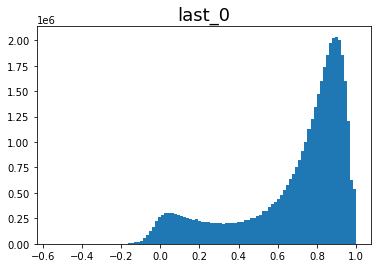

### 1
missing = 18299700


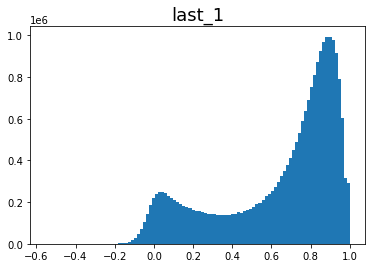

### 2
missing = 25596000


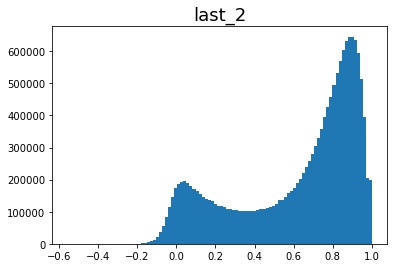

### 3
missing = 29590400


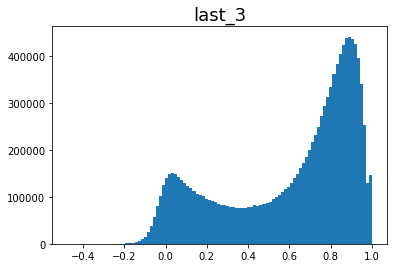

### 4
missing = 32129600


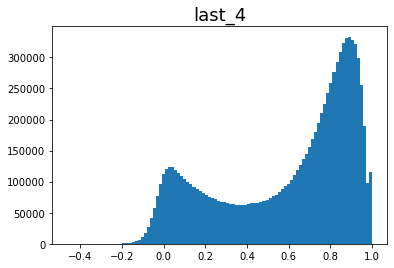

In [14]:
for k in range(5):
    print('###',k)
    nm = f'last_{k}'
    
    mask = users2[nm] != -1
    print('missing =', len(users2) - mask.sum() )
    
    x = build_dist(users2.item.values, users2[nm].values)
    
    users2.loc[mask,nm] = x[mask.to_numpy()]
    
    if SHOW_HIST:
        plt.hist(x[mask.to_numpy()], bins=100)
        plt.title(nm,size=18)
        plt.show()

### 0
missing = 0


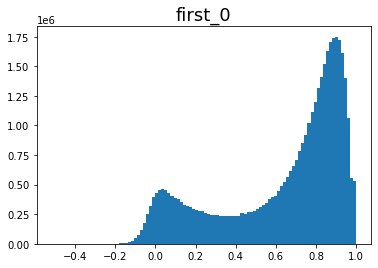

### 1
missing = 18299700


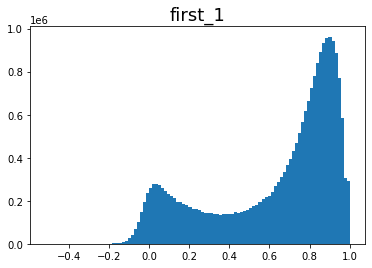

### 2
missing = 25596000


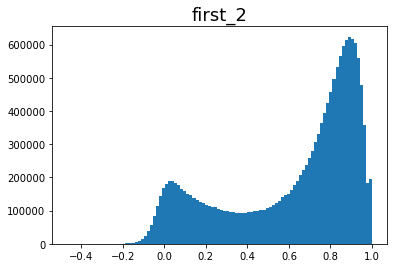

### 3
missing = 29590400


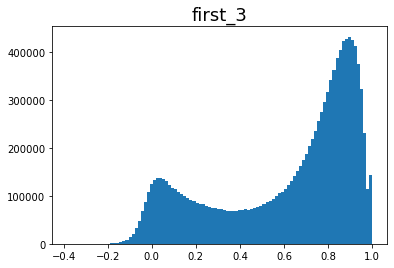

### 4
missing = 32129600


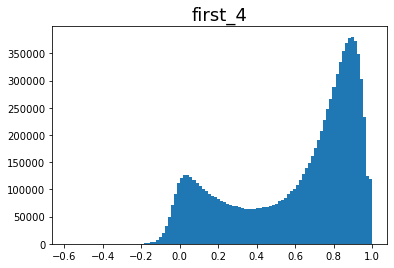

In [15]:
for k in range(5):
    print('###',k)
    nm = f'first_{k}'
    
    mask = users2[nm] != -1
    print('missing =', len(users2) - mask.sum() )
    
    x = build_dist(users2.item.values, users2[nm].values)
    
    users2.loc[mask,nm] = x[mask.to_numpy()]
    
    if SHOW_HIST:
        plt.hist(x[mask.to_numpy()], bins=100)
        plt.title(nm,size=18)
        plt.show()

### 0
missing = 35357800


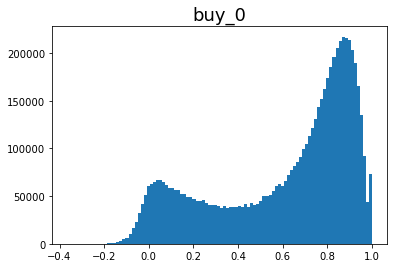

### 1
missing = 38477500


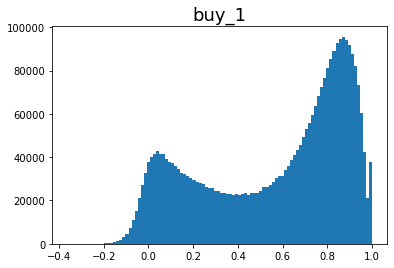

### 2
missing = 39859400


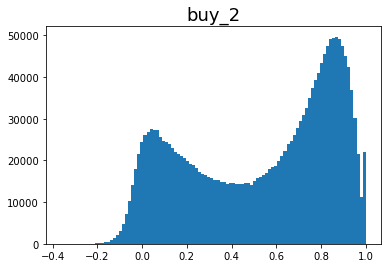

### 3
missing = 40503600


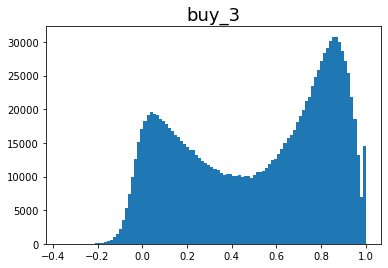

### 4
missing = 40891600


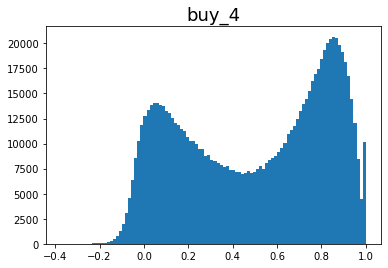

In [16]:
for k in range(5):
    print('###',k)
    nm = f'buy_{k}'
    
    mask = users2[nm] != -1
    print('missing =', len(users2) - mask.sum() )
    
    x = build_dist(users2.item.values, users2[nm].values)
    
    users2.loc[mask,nm] = x[mask.to_numpy()]
    
    if SHOW_HIST:
        plt.hist(x[mask.to_numpy()], bins=100)
        plt.title(nm,size=18)
        plt.show()

In [17]:
users2.head()

,index,user,item,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4
0,6208,12899841,832192,0.875015,0.875015,0.920771,0.920771,0.883375,0.317209,0.189090,0.189090,0.920771,0.844996,0.875015,0.189090,-1.0,-1.0,-1.0
1,6209,12899841,1436280,0.938803,0.938803,0.961316,0.961316,0.885746,0.259926,0.121525,0.121525,0.961316,0.915025,0.938803,0.121525,-1.0,-1.0,-1.0
2,6210,12899841,1194834,0.925122,0.925122,0.934195,0.934195,0.882324,0.241754,0.128613,0.128613,0.934195,0.908063,0.925122,0.128613,-1.0,-1.0,-1.0
3,6211,12899841,1745380,0.886287,0.886287,0.965675,0.965675,0.934610,0.179193,0.058325,0.058325,0.965675,0.951094,0.886287,0.058325,-1.0,-1.0,-1.0
4,6212,12899841,788882,0.829662,0.829662,0.951677,0.951677,0.951926,0.165775,0.069423,0.069423,0.951677,0.965367,0.829662,0.069423,-1.0,-1.0,-1.0


In [18]:
cols1 = [f'last_{x}' for x in range(5)]
cols2 = [f'first_{x}' for x in range(5)]
cols3 = [f'buy_{x}' for x in range(5)]
cols = cols1 + cols2 + cols3
len( cols )

15

In [19]:
for c in cols:
    users2.loc[users2[c]==-1,c] = np.nan

In [20]:
for k,c in enumerate( [cols1,cols2,cols3,cols] ):
    users2[f'e_mean_{k}'] = users2[cols].mean(axis=1)
    users2[f'e_std_{k}'] = users2[cols].std(axis=1)

In [21]:
users2 = users2.fillna(-1)

In [23]:
users2 = users2.to_pandas()

In [24]:
users2 = users2.sort_values('index').reset_index(drop=True).drop('index',axis=1)

In [25]:
users2.head()

,user,item,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4,e_mean_0,e_std_0,e_mean_1,e_std_1,e_mean_2,e_std_2,e_mean_3,e_std_3
0,12899779,59625,1.000000,-1.0,-1.0,-1.0,-1.0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0
1,12899779,731692,0.737480,-1.0,-1.0,-1.0,-1.0,0.737480,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.737480,0.0,0.737480,0.0,0.737480,0.0,0.737480,0.0
2,12899779,737445,0.801576,-1.0,-1.0,-1.0,-1.0,0.801576,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.801576,0.0,0.801576,0.0,0.801576,0.0,0.801576,0.0
3,12899779,941596,0.642863,-1.0,-1.0,-1.0,-1.0,0.642863,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.642863,0.0,0.642863,0.0,0.642863,0.0,0.642863,0.0
4,12899779,1253524,0.793857,-1.0,-1.0,-1.0,-1.0,0.793857,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.793857,0.0,0.793857,0.0,0.793857,0.0,0.793857,0.0


# EDA Columns

In [26]:
for i,c in enumerate(users2.columns):
    if not c in ['user','item']:
        users2[c] = users2[c].astype('float32')
    print(c,users2[c].dtype)

user int32
item int32
last_0 float32
last_1 float32
last_2 float32
last_3 float32
last_4 float32
first_0 float32
first_1 float32
first_2 float32
first_3 float32
first_4 float32
buy_0 float32
buy_1 float32
buy_2 float32
buy_3 float32
buy_4 float32
e_mean_0 float32
e_std_0 float32
e_mean_1 float32
e_std_1 float32
e_mean_2 float32
e_std_2 float32
e_mean_3 float32
e_std_3 float32


In [27]:
for c in users2.columns[:2]:
    print(c,', ',end='')

user , item , 

In [28]:
for c in users2.columns[2:]:
    print(c,', ',end='')
    users[c] = users2[c].values #to_numpy()
del users2
gc.collect()

last_0 , last_1 , last_2 , last_3 , last_4 , first_0 , first_1 , first_2 , first_3 , first_4 , buy_0 , buy_1 , buy_2 , buy_3 , buy_4 , e_mean_0 , e_std_0 , e_mean_1 , e_std_1 , e_mean_2 , e_std_2 , e_mean_3 , e_std_3 , 

2234

In [29]:
for c in users.columns:
    t = str(users[c].dtype)
    if (t=='int64'): 
        users[c] = users[c].astype('int32')
        print('convert',c,'to int32')
    if (t=='float64')|(t=='Int32')|(t=='Float32'):
        users[c] = users[c].astype('float32')
        print('convert',c,'to float32')

In [30]:
print( users.shape )
users.head()

(41795000, 224)


,user,item,pos,wgt,score_1,score_3,score_4,score_5,score_6,score_7,score_10,score_11,score_12,score_13,score_30,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,buy_ratio_5,count_item_5,count_user_5,repeat_5,buy_ratio_std_5,item_day_std_5,user_day_std_5,buy_ratio_0_6,buy_ratio_1_6,buy_ratio_2_6,buy_ratio_3_6,buy_ratio_4_6,buy_ratio_5_6,buy_ratio_6_6,count_item_0_6,count_item_1_6,count_item_2_6,count_item_3_6,count_item_4_6,count_item_5_6,count_item_6_6,count_user_0_6,count_user_1_6,count_user_2_6,count_user_3_6,count_user_4_6,count_user_5_6,count_user_6_6,item_day_std_6,user_day_std_6,buy_ratio,count_item,count_user,hour_mean,day_mean,repeat,buy_ratio_std,hour_std,day_std,buy_ratio3,count_item3,count_user3,hour_mean3,day_mean3,repeat3,buy_ratio_std3,hour_std3,day_std3,prev3,next3,orders3,carts3,order_repeat3,cart_repeat3,buy_ratio2,count_item2,unique_item2,hour_mean2,day_mean2,repeat2,buy_ratio_std2,hour_std2,day_std2,ts_max7,ts_min7,ts_diff7,z1,z2,z3,z4,z5,z6,buy_ratio7,count_item7,count_user7,hour_mean7,day_mean7,repeat7,buy_ratio_std7,hour_std7,day_std7,prev7,next7,orders7,carts7,order_repeat7,cart_repeat7,buy_ratio8,count_item8,count_user8,hour_mean8,day_mean8,repeat8,buy_ratio_std8,hour_std8,day_std8,prev8,next8,orders8,carts8,order_repeat8,cart_repeat8,buy_ratio9,count_item9,count_user9,hour_mean9,day_mean9,repeat9,buy_ratio_std9,hour_std9,day_std9,prev9,next9,orders9,carts9,order_repeat9,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10,z10,z11,buy_ratio11,count_item11,count_user11,hour_mean11,day_mean11,repeat11,buy_ratio_std11,hour_std11,day_std11,buy_ratio12,count_item12,count_user12,hour_mean12,day_mean12,repeat12,buy_ratio_std12,hour_std12,day_std12,buy_ratio13,count_item13,count_user13,hour_mean13,day_mean13,repeat13,buy_ratio_std13,hour_std13,day_std13,buy_ratio14,count_item14,unique_item14,hour_mean14,day_mean14,repeat14,buy_ratio_std14,hour_std14,day_std14,buy_ratio15,count_item15,unique_item15,hour_mean15,day_mean15,repeat15,buy_ratio_std15,hour_std15,day_std15,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4,e_mean_0,e_std_0,e_mean_1,e_std_1,e_mean_2,e_std_2,e_mean_3,e_std_3
0,12899779,59625,0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.414214,-1.0,0.071773,-1.0,-1.000,1.414214,1.414214,1.414214,1.414214,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,4.0,4.0,1.000000,0.000000,NaN,NaN,0.0,-1.00,-1.000000,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.377964,0.377964,0.000000,7.0,6.0,58189.570312,292703.84375,1.166667,0.000000,22522.156250,177373.40625,0.000000,1.0,1.0,79200.000000,338400.0000,1.00,-1.000000,-1.000000,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,0,0,0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,2.0,2.0,64435.000000,150835.00000,1.000000,0.000000,8051.117676,114136.937500,2.0,2.0,0.0,0.0,-1.0,-1.0,0.000000,6.0,5.0,66307.000000,325507.00000,1.200000,0.000000,7429.592773,169454.437500,5.0,5.0,0.0,0.0,-1.0,-1.0,0.000000,1.0,1.0,9485.000000,95885.00000,1.000000,-1.000000,-1.000000,-1.000000,1.0,1.0,0.0,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-1.0,-1.0,-1.0,-1.0,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0
1,12899779,731692,1,10.675,1.0,-3.0,-3.0,-3.0,0.5,-3.0,-3.000000,1.5,0.300000,4.0,5.990,-3.000000,-3.000000,-3.000000,-3.000000,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,1.0,0.5,1.0,0.140000,50.0,28.0,1.785714,0.404566,NaN,NaN,-1.0,0.25,0.500000,-1.0,-1.0,-1.0,0.0,-1.0,4.0,2.0,-1.0,-1.0,-1.0,1.0,-1.0,2.0,1.0,-1.0,-1.0,-1.0,1.0,1.527525,1.527525,0.162791,86.0,41.0

In [31]:
%%time
users.to_parquet(f'../../data/infer_with_features/train_v{VER}_LB_{PART}.pqt',index=False)

CPU times: user 4min 11s, sys: 9.06 s, total: 4min 20s
Wall time: 3min 14s
